## 4. Data Preparation

### Import the necessary packages

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import the CSV data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/EasyVisa.csv')
df.shape

(25480, 12)

### Show the first 5 records of the dataset

In [3]:
df.head().T

,0,1,2,3,4
case_id,EZYV01,EZYV02,EZYV03,EZYV04,EZYV05
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,High School,Master's,Bachelor's,Bachelor's,Master's
has_job_experience,N,Y,N,N,Y
requires_job_training,N,N,Y,N,N
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592.2029,83425.65,122996.86,83434.03,149907.39
unit_of_wage,Hour,Year,Year,Year,Year


### Drop `case_id` column from the dataset

In [4]:
# Remove the column
del df['case_id']
df.shape

(25480, 11)

### Encode target variable for classification

In [5]:
df.case_status.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [6]:
# Replace Certified/Denied with a number; 1 (Cerified) or 0 (Denied)
df.case_status = (df.case_status == 'Certified').astype(int)
df.case_status[:5]

0    0
1    1
2    0
3    0
4    1
Name: case_status, dtype: int64

### Set up the validation framework

#### Prepare the $X$ feature matrix and the $y$ target variable

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Perform the train/validation/test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.case_status.values
y_val = df_val.case_status.values
y_test = df_test.case_status.values

del df_train['case_status']
del df_val['case_status']
del df_test['case_status']

In [9]:
df_train.shape, df_val.shape, df_test.shape

((15288, 10), (5096, 10), (5096, 10))

In [10]:
df_train.head().T

,0,1,2,3,4
continent,Asia,North America,Asia,Asia,Europe
education_of_employee,High School,Bachelor's,Bachelor's,Bachelor's,Doctorate
has_job_experience,N,N,Y,N,N
requires_job_training,N,N,N,N,Y
no_of_employees,1147,1446,3645,845,4020
yr_of_estab,1995,2002,2014,1946,1892
region_of_employment,Island,Northeast,South,South,South
prevailing_wage,55253.09,85496.8,65132.85,62528.22,64325.43
unit_of_wage,Year,Year,Year,Year,Year
full_time_position,Y,Y,Y,Y,Y


In [11]:
y_train[:5]

array([0, 0, 1, 1, 1])

In [12]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [13]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [14]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

### Feature Importance Analysis

This step aims to determine the most influential factors in predicting the visa application outcome.

#### Calculate Certify Rate and Risk Ratio
These metrics help assess the association between categorical features and the target variable:
- **Certify Rate:** 
  * Calculated as the proportion of certified cases within a specific category of a feature. 
  * A higher certify rate (diff $> 0$) within a category suggests a greater likelihood of certification for that category.
  * The difference between a category's certify rate and the overall certification rate provides an indication of the category's association with the target variable. 
  * Larger differences generally signify stronger associations.
- **Risk Ratio:** 
  * Calculated as the ratio of the probability of certification within a specific category to the overall probability of certification.
  * A risk ratio greater than 1 indicates that the category is more likely to be certified compared to the overall average. 
  * A risk ratio less than 1 indicates a lower likelihood of certification for that category. 
  * Risk ratios provide a relative measure of the association between a category and the target variable.

In [15]:
# Calculate the certify rate of the entire full train dataset
global_certify_rate = df_full_train.case_status.mean()
round(global_certify_rate, 2)

np.float64(0.67)

In [16]:
from IPython.display import display

In [17]:
# Calculate the difference and risk for all categorical variables
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).case_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_certify_rate
    df_group['risk'] = df_group['mean'] / global_certify_rate
    display(df_group)
    print()
    print()

continent


,mean,count,diff,risk
continent,,,,
Africa,0.715262,439,0.047238,1.070713
Asia,0.651711,13440,-0.016313,0.975581
Europe,0.793698,3015,0.125674,1.188128
North America,0.624811,2652,-0.043212,0.935313
Oceania,0.651613,155,-0.016411,0.975433
South America,0.575403,683,-0.092621,0.861350




education_of_employee


,mean,count,diff,risk
education_of_employee,,,,
Bachelor's,0.622198,8208,-0.045826,0.931401
Doctorate,0.869175,1781,0.201151,1.301113
High School,0.348540,2740,-0.319484,0.521748
Master's,0.784716,7655,0.116692,1.174682




has_job_experience


,mean,count,diff,risk
has_job_experience,,,,
N,0.562683,8543,-0.105341,0.842309
Y,0.744025,11841,0.076001,1.113770




requires_job_training


,mean,count,diff,risk
requires_job_training,,,,
N,0.667538,17987,-0.000486,0.999272
Y,0.671673,2397,0.003649,1.005462




region_of_employment


,mean,count,diff,risk
region_of_employment,,,,
Island,0.598726,314,-0.069298,0.896264
Midwest,0.756133,3424,0.088109,1.131895
Northeast,0.631570,5746,-0.036454,0.945430
South,0.702063,5622,0.034039,1.050955
West,0.618416,5278,-0.049608,0.925739




unit_of_wage


,mean,count,diff,risk
unit_of_wage,,,,
Hour,0.344484,1704,-0.323540,0.515675
Month,0.625000,72,-0.043024,0.935595
Week,0.621622,222,-0.046402,0.930538
Year,0.698738,18386,0.030714,1.045978




full_time_position


,mean,count,diff,risk
full_time_position,,,,
N,0.686429,2159,0.018405,1.027551
Y,0.665844,18225,-0.002180,0.996736


#### Calculate Mutual Information 
Mutual Information (MI) measures the amount of information one variable provides about another. 

We will rank the features based on their MI scores. The feature with the highest MI score is considered the most important, followed by the feature with the second-highest score, and so on. 

In [18]:
from sklearn.metrics import mutual_info_score

In [19]:
def mutual_info_certify_score(series):
    return mutual_info_score(series, df_full_train.case_status)

In [26]:
# Calculate mutual information scores of all categorical variables
mi = df_full_train[categorical].apply(mutual_info_certify_score)
# Sort the result such that the most important features come first
mi.sort_values(ascending=False)

education_of_employee    0.052196
unit_of_wage             0.020227
has_job_experience       0.017954
continent                0.007389
region_of_employment     0.006231
full_time_position       0.000091
requires_job_training    0.000004
dtype: float64

**Top 5 Features:** 
* Based on Mutual Information (MI) scores, the top 5 features for inclusion in the model are:
    1. `education_of_employee` (MI: 0.052196)
    2. `unit_of_wage` (MI: 0.020227)
    3. `has_job_experience` (MI: 0.017954)
    4. `continent` (MI: 0.007389)
    5. `region_of_employment` (MI: 0.006231)

**Feature Exclusion:**
* `full_time_position` has a very low MI score (0.000091), suggesting limited predictive power. Consider excluding it from the model.
* The MI score for `requires_job_training` (0.000004) is extremely low, confirming our earlier finding of no significant association with the target variable using the Chi-Square Test of Independence. This feature will be excluded from the model.

#### Calculate Correlation Coefficient

The Pearson correlation coefficient measures the linear relationship between two continuous variables. It can be used to assess the strength and direction of the linear relationship between numerical features and the binary target variable.

In [27]:
df_full_train[numerical].corrwith(df_full_train.case_status)

no_of_employees    0.004810
yr_of_estab        0.008096
prevailing_wage    0.075117
dtype: float64

Based on the correlation coefficient score of 0.075117 for `prevailing_wage`, we can infer a weak positive correlation between prevailing wage and the likelihood of visa certification by the OFLC.

In [28]:
# Rank the importance of each numerical features
df_full_train[numerical].corrwith(df_full_train.case_status).abs().sort_values(ascending=False)

prevailing_wage    0.075117
yr_of_estab        0.008096
no_of_employees    0.004810
dtype: float64

This approach allows us to understand the relationship between numerical variables and the likelihood of visa application approval.

### Feature Extraction

#### Determine company age based on the current year and establishment year

In [31]:
# Import date class from datetime module
from datetime import date
 
# Retrieve today's date
current_date = date.today()
print(f'Current Date: {current_date}')
current_year = current_date.year
print(f'Current Year: {current_year}')

Current Date: 2025-01-14
Current Year: 2025


In [32]:
# Add a new column for company age
df_train['company_age'] = current_year - df_train['yr_of_estab']
df_val['company_age'] = current_year - df_val['yr_of_estab']

# Remove the year of establishment column
del df_train['yr_of_estab']
del df_val['yr_of_estab']

In [33]:
df_train.head().T

,0,1,2,3,4
continent,Asia,North America,Asia,Asia,Europe
education_of_employee,High School,Bachelor's,Bachelor's,Bachelor's,Doctorate
has_job_experience,N,N,Y,N,N
requires_job_training,N,N,N,N,Y
no_of_employees,1147,1446,3645,845,4020
region_of_employment,Island,Northeast,South,South,South
prevailing_wage,55253.09,85496.8,65132.85,62528.22,64325.43
unit_of_wage,Year,Year,Year,Year,Year
full_time_position,Y,Y,Y,Y,Y
company_age,30,23,11,79,133


In [34]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

### Feature Transformation

In [35]:
numerical

Index(['no_of_employees', 'prevailing_wage', 'company_age'], dtype='object')

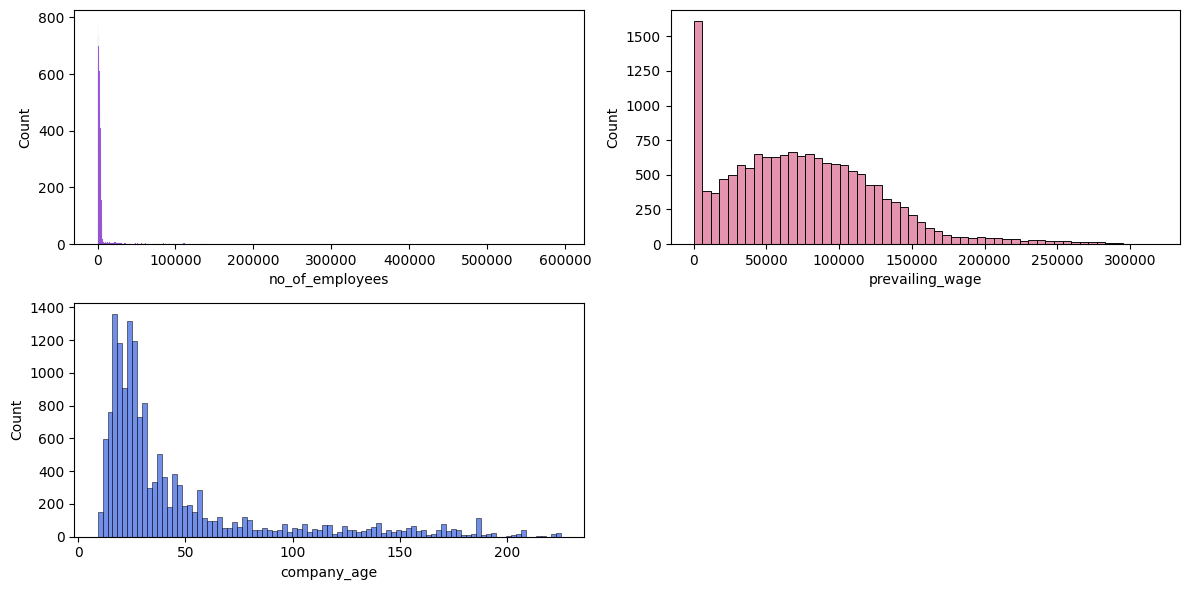

In [36]:
# Plot distribution of numerical features before scaling
plt.figure(figsize=(12, 6))

colors = ['blueviolet', 'palevioletred', 'royalblue']

for i, feature in enumerate(numerical):
    plt.subplot(2, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_train[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [38]:
# Check Skewness
df_train[numerical].skew(axis=0)

no_of_employees    12.856499
prevailing_wage     0.746797
company_age         2.039508
dtype: float64

#### Experiment with Yeo-Johnson transformation

In [39]:
from sklearn.preprocessing import PowerTransformer

In [40]:
transform_features = ['no_of_employees', 'company_age']

pt = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt.fit_transform(df_train[transform_features])

In [41]:
df_transformed = pd.DataFrame(X_train_transformed, columns=transform_features)

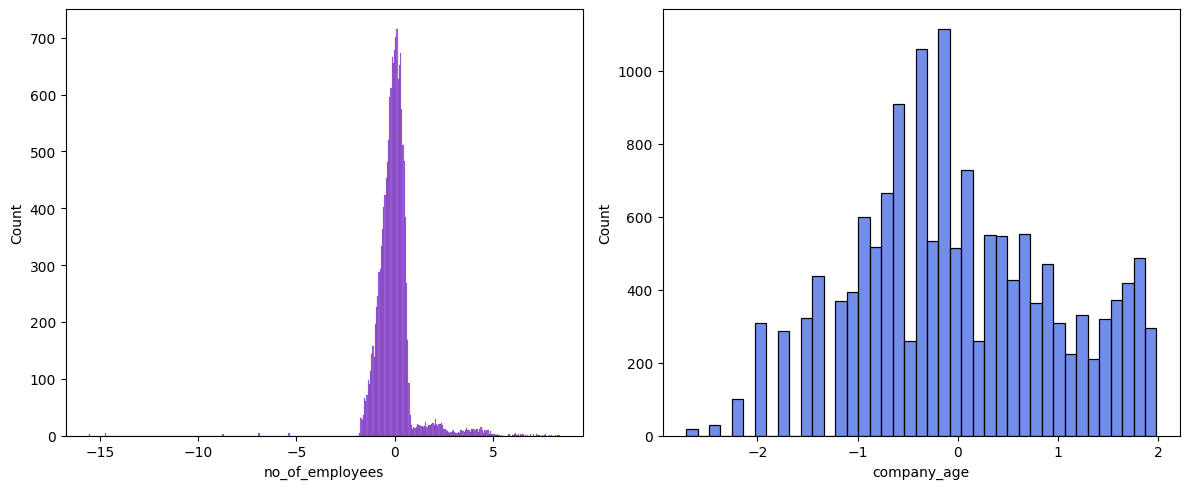

In [42]:
# Plot distribution of numerical features after scaling
plt.figure(figsize=(12, 5))

colors = ['blueviolet', 'royalblue']

for i, feature in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_transformed[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [43]:
# Check Skewness
df_transformed.skew(axis=0)

no_of_employees    0.467091
company_age        0.113265
dtype: float64

#### Perform Feature Encoding and Scaling

In [44]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

In [45]:
# Create ColumnTransformer with 3 types of transformers
oh_columns = ['continent', 'unit_of_wage', 'region_of_employment']
or_columns = ['has_job_experience', 'requires_job_training', 'full_time_position', 'education_of_employee']
transform_columns= ['no_of_employees', 'company_age']

oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipeline = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("OrdinalEncoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipeline, transform_columns),
        ("StandardScaler", numeric_transformer, numerical)
    ]
)

In [46]:
X_train = preprocessor.fit_transform(df_train)
X_train[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  2.        , -0.39686515,
       -0.00479883, -0.18997351, -0.3702257 , -0.36924446])

In [47]:
X_train.shape

(15288, 24)

In [48]:
preprocessor.get_feature_names_out()

array(['OneHotEncoder__continent_Africa', 'OneHotEncoder__continent_Asia',
       'OneHotEncoder__continent_Europe',
       'OneHotEncoder__continent_North America',
       'OneHotEncoder__continent_Oceania',
       'OneHotEncoder__continent_South America',
       'OneHotEncoder__unit_of_wage_Hour',
       'OneHotEncoder__unit_of_wage_Month',
       'OneHotEncoder__unit_of_wage_Week',
       'OneHotEncoder__unit_of_wage_Year',
       'OneHotEncoder__region_of_employment_Island',
       'OneHotEncoder__region_of_employment_Midwest',
       'OneHotEncoder__region_of_employment_Northeast',
       'OneHotEncoder__region_of_employment_South',
       'OneHotEncoder__region_of_employment_West',
       'OrdinalEncoder__has_job_experience',
       'OrdinalEncoder__requires_job_training',
       'OrdinalEncoder__full_time_position',
       'OrdinalEncoder__education_of_employee',
       'Transformer__no_of_employees', 'Transformer__company_age',
       'StandardScaler__no_of_employees',
       '

In [49]:
df_train.head(1)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,High School,N,N,1147,Island,55253.09,Year,Y,30
